https://dev.azure.com/tankerkoenig/_git/tankerkoenig-data

```
├── LICENSE
├── Makefile           <- Makefile with commands like `make data` or `make train`
├── README.md          <- The top-level README for developers using this project.
├── data
│   ├── external       <- Data from third party sources.
│   ├── interim        <- Intermediate data that has been transformed.
│   ├── processed      <- The final, canonical data sets for modeling.
│   └── raw            <- The original, immutable data dump.
│
├── docs               <- A default Sphinx project; see sphinx-doc.org for details
│
├── models             <- Trained and serialized models, model predictions, or model summaries
│
├── notebooks          <- Jupyter notebooks. Naming convention is a number (for ordering),
│                         the creator's initials, and a short `-` delimited description, e.g.
│                         `1.0-jqp-initial-data-exploration`.
│
├── references         <- Data dictionaries, manuals, and all other explanatory materials.
│
├── reports            <- Generated analysis as HTML, PDF, LaTeX, etc.
│   └── figures        <- Generated graphics and figures to be used in reporting
│
├── requirements.txt   <- The requirements file for reproducing the analysis environment, e.g.
│                         generated with `pip freeze > requirements.txt`
│
├── setup.py           <- Make this project pip installable with `pip install -e`
├── src                <- Source code for use in this project.
│   ├── __init__.py    <- Makes src a Python module
│   │
│   ├── data           <- Scripts to download or generate data
│   │   └── make_dataset.py
│   │
│   ├── features       <- Scripts to turn raw data into features for modeling
│   │   └── build_features.py
│   │
│   ├── models         <- Scripts to train models and then use trained models to make
│   │   │                 predictions
│   │   ├── predict_model.py
│   │   └── train_model.py
│   │
│   └── visualization  <- Scripts to create exploratory and results oriented visualizations
│       └── visualize.py
│
└── tox.ini            <- tox file with settings for running tox; see tox.readthedocs.io
```

path_stationsA = r'S:\github.com\cprima\cprimanet\dat\tankerkoenig-stations-wolfsburg.csv'
upload_blob_file(bucket_name, path_stationsA, "data_filtered_tk_stations_wolfsburg.csv")

In [1]:
import os
import datetime
import time
import requests
from urllib.parse import urlparse
import pandas as pd
import calendar
import math
import matplotlib.pyplot as plt

from google.cloud import storage

In [12]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:

tk_stations_url_tpl = "https://dev.azure.com/tankerkoenig/362e70d1-bafa-4cf7-a346-1f3613304973/_apis/git/repositories/0d6e7286-91e4-402c-af56-fa75be1f223d/items?path=/stations/{year:n}/{month}/{year:n}-{month:02d}-{day:02d}-stations.csv"
tk_prices_url_tpl = "https://dev.azure.com/tankerkoenig/362e70d1-bafa-4cf7-a346-1f3613304973/_apis/git/repositories/0d6e7286-91e4-402c-af56-fa75be1f223d/items?path=/prices/{year:n}/{month}/{year:n}-{month:02d}-{day:02d}-prices.csv"
tk_prices_filename_tpl = "data/external/tankerkoenig/prices/prices_{year}-{month:02d}-{day:02d}.csv"
tk_stations_filename_tpl = "data/external/tankerkoenig/stations/current.csv"
my_subset_prices_location_date_timespan_filename_tpl = "data_interim/subset_prices_{location}_{from_year}-{from_month:02d}-{from_day:02d}_{from_hour:02d}-{from_minute:02d}-{from_second:02d}_-_{to_year}-{to_month:02d}-{to_day:02d}_{to_hour:02d}-{to_minute:02d}-{to_second:02d}.csv"
my_weeklyaggregate_prices_location_date_timespan_filename_tpl = "data_processed/weeklyaggregate_prices_{from_year}-{from_month:02d}-{from_day:02d}_{from_hour:02d}-{from_minute:02d}-{from_second:02d}_-_{to_year}-{to_month:02d}-{to_day:02d}_{to_hour:02d}-{to_minute:02d}-{to_second:02d}.csv"

figure_subtitle_tpl = "vom {from_day:02d}.{from_month:02d}. bis {to_day:02d}.{to_month:02d}. zwischen {from_hour:02d}:{from_minute:02d} und {to_hour:02d}:{to_minute:02d}"

yesterday = datetime.date.today() - datetime.timedelta(days=1)
#day_delta = datetime.timedelta(days=1)
days_range = 3  # 0
end_date = datetime.date.today() - datetime.timedelta(days=1)
start_date = end_date - days_range*datetime.timedelta(days=1)
daysOfWeek = {0: 'Montag', 1: 'Dienstag', 2: 'Mittwoch',
              3: 'Donnerstag', 4: 'Freitag', 5: 'Samstag', 6: 'Sonntag'}

tk_stations_url_current = tk_stations_url_tpl.format(
    year=yesterday.year, month=yesterday.month, day=yesterday.day) + "&download=true"

bucket_name = "2021.gasprices.cprima.net"

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r"C:\Users\cpm\Documents\gae-gasprices-service-account-file.json"

In [7]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r"C:\Users\cpm\Documents\gae-gasprices-service-account-file.json"

In [3]:
def getDaysSinceYesterdayAsList(days_range):
    """Returns datetime objects since yesterday as a list"""
    retval = []
    end_date = datetime.date.today() - datetime.timedelta(days = 1)
    start_date = end_date - days_range * datetime.timedelta(days=1)
    for i in range((end_date - start_date).days):
        retval.append(end_date - i * datetime.timedelta(days=1))
    return retval

def formatStringPaddedYMD(url_tpl, tmp_date):
    """Formats a string with padded day and month integers from datetime object"""
    return url_tpl.format(year=tmp_date.year,month=tmp_date.month,day=tmp_date.day)

def upload_blob_file(bucket_name, source_file_name, destination_blob_name, metadata={'foo': 'bar'}):
    """Uploads a file to the bucket."""
    if destination_blob_name.endswith(".csv"):
        content_type = 'text/csv'
    elif destination_blob_name.endswith(".json"):
        content_type = 'application/json'
    elif destination_blob_name.endswith(".png"):
        content_type = 'image/png'
    else:
        content_type = 'text/plain'
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(source_file_name, content_type=content_type)
    blob.metadata = metadata
    blob.patch()
    return

def upload_blob_string(bucket_name, source_string, destination_blob_name, metadata={'foo': 'bar'}):
    """Uploads a string as file to the bucket. Depends on `from google.cloud import storage`"""
    if destination_blob_name.endswith(".csv"):
        content_type = 'text/csv'
    elif destination_blob_name.endswith(".json"):
        content_type = 'application/json'
    elif destination_blob_name.endswith(".png"):
        content_type = 'image/png'
    else:
        content_type = 'text/plain'
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_string(source_string, content_type=content_type)
    blob.metadata = metadata
    blob.patch()
    return

#def requestUrlsAndUploadBlobs(filename, source_string):
#    upload_blob_string(bucket_name, source_string, filename)
#    return

def list_blobs(bucket_name):
    """Lists all the blobs in the bucket."""
    storage_client = storage.Client()
    blobs = storage_client.list_blobs(bucket_name)
    retval = []
    for blob in blobs:
        retval.append(blob.name)
    return retval

def list_gs_files(endswith="", startswith=""):
    retval = []
    for filename in list_blobs(bucket_name):
        if filename.endswith(endswith) and filename.startswith(startswith):
            retval.append(filename)
    retval.sort(reverse=False)
    return retval

def retrievePricefiles():
    """@todo: rename"""
    existing_files = list_gs_files(endswith="csv")
    for d in getDaysSinceYesterdayAsList(days_range):
        url = formatStringPaddedYMD(tk_prices_url_tpl, d) + "&download=true"
        filename = formatStringPaddedYMD(tk_prices_filename_tpl, d)
        if filename in existing_files:
            pass
        else:
            r = requests.get(url)
            metadata = {'type': 'prices', 'location': 'deutschland'}
            upload_blob_string(bucket_name, r.content, filename, metadata)
    return

def retrieveStationfile():
    """@todo: rename"""
    url = formatStringPaddedYMD(tk_stations_url_tpl, datetime.date.today() - datetime.timedelta(days = 1)) + "&download=true"
    filename = tk_stations_filename_tpl
    r = requests.get(url)
    upload_blob_string(bucket_name, r.content, filename)
    return

def retrieve_data():
    retrievePricefiles()
    retrieveStationfile()

In [4]:
days_range = 3
retrieve_data()

In [1]:
def getPricefilesFromStorage(days_range=30, fullweeks=False):
    retval = []
    needle_list = []

    if fullweeks:
        for d in getDaysOfPreviousWeeksAsList(weeks=fullweeks):
            needle_list.append(d.strftime("data_external_tk_prices_%Y-%m-%d.csv"))
    else:
        for d in getDaysSinceYesterdayAsList(days_range):
            needle_list.append(d.strftime("data_external_tk_prices_%Y-%m-%d.csv"))

    csv_files_list = list_gs_files(endswith="csv", startswith="data_external_tk_prices_")
    for file in csv_files_list:
        if file in needle_list:
            retval.append(file)
    return retval

def get_dataframe_prices_from_storage(days_range=30, fullweeks=False):
    list_temp_raw = []
    filenames = getPricefilesFromStorage(days_range, fullweeks)
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for filename in filenames:
        temp = pd.read_csv('gs://'+bucket_name+'/'+filename, encoding='utf-8')
        list_temp_raw.append(temp)
    df = pd.concat(list_temp_raw)
    df = df.drop(['dieselchange', 'e5change', 'e10change'], axis=1)
    df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True)
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = pd.Categorical(df['weekday'], categories=days, ordered=True)
    df['quarter'] = df['date'].dt.to_period('Q')
    return df

def get_dataframe_stations_from_storage(location="wolfsburg"):
    df = pd.concat([pd.read_csv(
        'gs://'+bucket_name+'/'+'data_filtered_tk_stations_'+location+'.csv',
         encoding='utf-8')], ignore_index = True)
    df = df.drop(['dist', 'diesel', 'e5', 'e10', 'isOpen'], axis=1)
    return df

def getDaysOfPreviousWeeksAsList(weeks=3):
    """Returns datetime objects of previous full weeks as a list"""
    retval = []
    today = datetime.date.today()
    offsetA = weeks * 7 + 1
    offsetB = (weeks * 7) - 1
    start_date = today - datetime.timedelta(days=today.weekday()) - datetime.timedelta(days = offsetA)
    end_date = start_date + datetime.timedelta(days=offsetB)

    for i in range((end_date - start_date).days):
        retval.append(end_date - i*datetime.timedelta(days=1))
    return retval

def merge_dataframes_stations_prices(location, days_range=30, fullweeks=False):
    df_prices = get_dataframe_prices_from_storage(days_range, fullweeks=False)
    df_stations = get_dataframe_stations_from_storage(location)
    df_merged = pd.merge(df_prices, df_stations, left_on='station_uuid',right_on='id',how='inner',suffixes=('_left','_right'))
    df_merged.index=pd.to_datetime(df_merged['date'], utc=True)
    return df_merged

def calculate_start_date(days_range=30, fullweeks=False):
    if fullweeks:
        return min(getDaysOfPreviousWeeksAsList(fullweeks))
    else:
        return min(getDaysSinceYesterdayAsList(days_range))

def calculate_end_date(days_range=30, fullweeks=False):
    if fullweeks:
        return max(getDaysOfPreviousWeeksAsList(fullweeks))
    else:
        return max(getDaysSinceYesterdayAsList(days_range))

def format_filename_tpl(tpl, location, from_date, thru_date, timespan):
    try:
        from_time = time.strptime(timespan['from'], '%H:%M:%S')
    except ValueError:
        from_time = time.strptime(timespan['from'], '%H:%M')
    except Exception as e:
        print(e)
    try:
        thru_time = time.strptime(timespan['thru'], '%H:%M:%S')
    except ValueError:
        thru_time = time.strptime(timespan['thru'], '%H:%M')
    except Exception as e:
        print(e)
    finally:
        f = tpl.format(
            location=location,
            from_year=from_date.year, from_month=from_date.month, from_day=from_date.day,
            from_hour=from_time.tm_hour, from_minute=from_time.tm_min, from_second=from_time.tm_sec,
            to_year=thru_date.year, to_month=thru_date.month, to_day=thru_date.day,
            to_hour=thru_time.tm_hour, to_minute=thru_time.tm_min, to_second=thru_time.tm_sec
        )
    return f

def make_datasets(location="wolfsburg", days_range=30, fullweeks=False):
    from_date = calculate_start_date(days_range, fullweeks)
    thru_date = calculate_end_date(days_range, fullweeks)
    df = merge_dataframes_stations_prices(location, days_range, fullweeks)
    #df = df_merged
    timespans = [{'from':'00:00', 'thru':'23:59:59'}, {'from':'17:00', 'thru':'21:59:59'}]
    for timespan in timespans:
        f = format_filename_tpl(my_subset_prices_location_date_timespan_filename_tpl, location, from_date, thru_date, timespan)
        df4 = df.to_csv(None, sep=',', header=True, index=False, encoding='utf-8')
        upload_blob_string(bucket_name, df4, f)

        datafilename = format_filename_tpl(my_weeklyaggregate_prices_location_date_timespan_filename_tpl, location, from_date, thru_date, timespan)
        plotfilename = datafilename.replace(".csv", ".png")
        plotfilename = plotfilename.replace("data_", "plot_")
        subtitle = format_filename_tpl(figure_subtitle_tpl, location, from_date, thru_date, timespan)
        #existing_files = list_gs_files(endswith="csv")
        df2 = df.between_time(timespan['from'], timespan['thru']).groupby('weekday')[['e5', 'e10', 'diesel']].mean()
        generate_save_plot(df2, location, subtitle, plotfilename)
        df3 = df2.to_csv(None, sep=',', header=True, index=True, encoding='utf-8')
        upload_blob_file(bucket_name, plotfilename, plotfilename)
        upload_blob_string(bucket_name, df3, datafilename)
    return df

In [18]:
def generate_save_plot(df, location, subtitle, filename):
    plt.rcdefaults()
    plt.style.use('Solarize_Light2')
    px = 1/plt.rcParams['figure.dpi']

    serif_font = {'fontname':'Linux Biolinum'}
    #plt.rcParams['font.family'] = serif_font
    plt.rcParams.update({'font.sans-serif':'Linux Biolinum'})
    colors = plt.rcParams["axes.prop_cycle"]()

    px = 1/plt.rcParams['figure.dpi']
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(640*px, 360*px))

    fig.suptitle("Benzinpreise in "+location.capitalize(), fontsize=24, **serif_font)

    e5min = df['e5'][df['e5'] > 0.1].min()
    e5max = df['e5'][df['e5'] > 0.1].max()
    e5min = (math.floor(e5min*100)/100)-0.01
    e5max = (math.ceil(e5max*100)/100)+0.01
    #print(e5min, e5max)
    dieselmin = df['diesel'][df['diesel'] > 0.1].min()
    dieselmax = df['diesel'][df['diesel'] > 0.1].max()
    dieselmin = (math.floor(dieselmin*100)/100)-0.01
    dieselmax = (math.ceil(dieselmax*100)/100)+0.01

    c = next(colors)["color"]
    ax1.plot(df.e5, label='e5', color=c)
    ax1.set_title(subtitle)
    ax1.legend()
    ax1.set_ylim([e5min, e5max])

    c = next(colors)["color"]
    ax2.plot(df.diesel, label='diesel', color=c)
    ax2.legend()
    ax2.set_ylim([dieselmin, dieselmax])

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

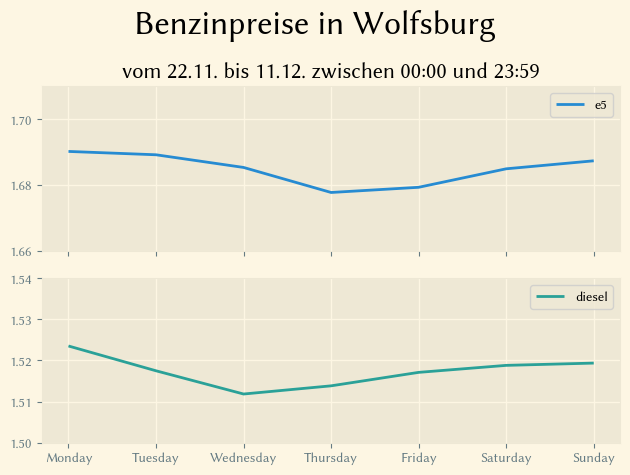

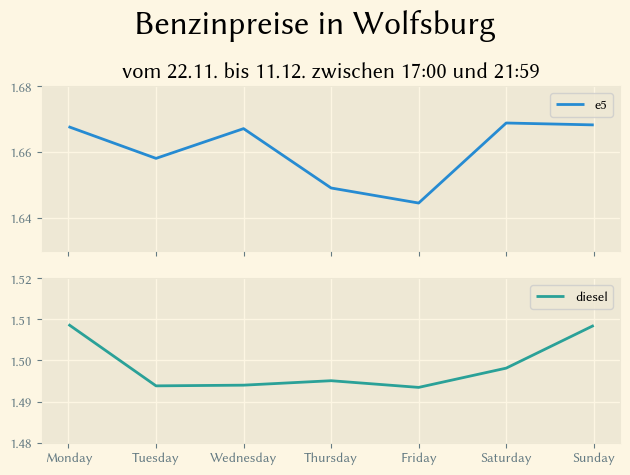

In [8]:
df_merged=make_datasets(location="wolfsburg", days_range=30, fullweeks=3)

In [230]:
storage_client = storage.Client()
blobs = storage_client.list_blobs('2021.gasprices.cprima.net')
data = []
for blob in blobs:
    if blob.name.startswith('data/p') and  blob.name.endswith('.csv') and blob.metadata['type'] == 'prices':
        #print(blob.name, blob.metadata)
        new = blob.metadata
        new['blobname'] = blob.name
        data.append(new)

df_prices = pd.DataFrame.from_dict(data)
df_prices

,from_date,thru_date,time_of_day,location,timespan,type,from_time,thru_time,blobname
0,2021-11-26,2021-12-17,full,wolfsburg,21,prices,00-00-00,23-59-59,data/processed/wolfsburg/prices_2021-11-26_00-...
1,2021-11-26,2021-12-17,earlyevening,wolfsburg,21,prices,17-00-00,21-59-59,data/processed/wolfsburg/prices_2021-11-26_17-...


In [20]:
def visualize_weekly(event, context):
    if "data/processed/wolfsburg/prices_" in event['name']:
        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        translate_dict = {'Monday':'Mo','Tuesday':'Di','Wednesday':'Mi','Thursday':'Do','Friday':'Fr','Saturday':'Sa','Sunday':'So'}
        storage_client = storage.Client()
        blobs = storage_client.list_blobs('2021.gasprices.cprima.net')
        data = []
        for blob in blobs:
            if blob.name.startswith('data/p') and  blob.name.endswith('.csv') and blob.metadata['type'] == 'prices':
                #print(blob.name, blob.metadata)
                new = blob.metadata
                new['blobname'] = blob.name
                data.append(new)

        df_prices = pd.DataFrame.from_dict(data)

        current = df_prices[df_prices['thru_date']==df_prices['thru_date'].max()][df_prices['time_of_day'].str.match('earlyevening')].iloc[0]

        from_datetime = datetime.datetime.strptime(current['from_date'] + ' ' + current['from_time'], '%Y-%m-%d %H-%M-%S')
        thru_datetime = datetime.datetime.strptime(current['thru_date'] + ' ' + current['thru_time'], '%Y-%m-%d %H-%M-%S')
        subtitle = "vom {from_day:02d}.{from_month:02d}. bis {to_day:02d}.{to_month:02d}. zwischen {from_hour:02d}:{from_minute:02d} und {to_hour:02d}:{to_minute:02d}"
        subtitle = subtitle.format(            from_year=from_datetime.year, from_month=from_datetime.month, from_day=from_datetime.day,
                    from_hour=from_datetime.hour, from_minute=from_datetime.minute, from_second=from_datetime.second,
                    to_year=thru_datetime.year, to_month=thru_datetime.month, to_day=thru_datetime.day,
                    to_hour=thru_datetime.hour, to_minute=thru_datetime.minute, to_second=thru_datetime.second)

        df9 = pd.read_csv('gs://'+'2021.gasprices.cprima.net'+'/'+current['blobname'], encoding='utf-8')

        df9['date'] = pd.to_datetime(df9['date'], errors='coerce', utc=True)
        df9['weekday'] = df9['date'].dt.day_name()
        df9['weekday'] = pd.Categorical(df9['weekday'], categories=days, ordered=True)
        df9 = df9.groupby('weekday')[['e5', 'e10', 'diesel']].mean().rename(index=translate_dict, inplace=False)

        generate_save_plot(df9, 'wolfsburg', subtitle, 'reports_figures_wolfsburg_earlyevening_current.png')

In [301]:
del(current['blobname'])
current

from_date        2021-11-26
thru_date        2021-12-17
time_of_day    earlyevening
location          wolfsburg
timespan                 21
type                 prices
from_time          17-00-00
thru_time          21-59-59
Name: 1, dtype: object

In [302]:
bbb = current.to_dict()
bbb

{'from_date': '2021-11-26',
 'thru_date': '2021-12-17',
 'time_of_day': 'earlyevening',
 'location': 'wolfsburg',
 'timespan': '21',
 'type': 'prices',
 'from_time': '17-00-00',
 'thru_time': '21-59-59'}

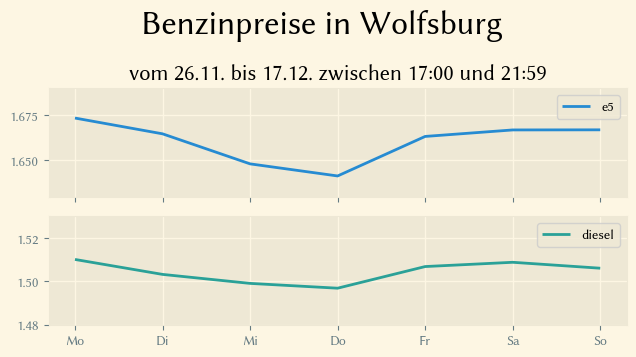

In [21]:
visualize_weekly({'name':'data/processed/wolfsburg/prices_'}, "")

In [280]:
from_datetime = datetime.datetime.strptime(current['from_date'] + ' ' + current['from_time'], '%Y-%m-%d %H-%M-%S')
thru_datetime = datetime.datetime.strptime(current['thru_date'] + ' ' + current['thru_time'], '%Y-%m-%d %H-%M-%S')

In [287]:
subtitle = "vom {from_day:02d}.{from_month:02d}. bis {to_day:02d}.{to_month:02d}. zwischen {from_hour:02d}:{from_minute:02d} und {to_hour:02d}:{to_minute:02d}"
subtitle = subtitle.format(            from_year=from_datetime.year, from_month=from_datetime.month, from_day=from_datetime.day,
            from_hour=from_datetime.hour, from_minute=from_datetime.minute, from_second=from_datetime.second,
            to_year=thru_datetime.year, to_month=thru_datetime.month, to_day=thru_datetime.day,
            to_hour=thru_datetime.hour, to_minute=thru_datetime.minute, to_second=thru_datetime.second)
print(subtitle)

vom 26.11. bis 17.12. zwischen 17:00 und 21:59


In [261]:
df9

,e5,e10,diesel
weekday,,,
Mo,1.673520,1.616198,1.510133
Di,1.664779,1.607712,1.503227
Mi,1.639915,1.583085,1.484572
Do,1.641422,1.584625,1.496853
Fr,1.669501,1.612908,1.511243
Sa,1.666931,1.609826,1.508819
So,1.666993,1.610115,1.506084


In [ ]:
def dsadasdsalist_blobs(bucket_name):
    """Lists all the blobs in the bucket."""
    storage_client = storage.Client()
    blobs = storage_client.list_blobs(bucket_name)
    retval = []
    for blob in blobs:
        retval.append(blob.name)
    return retval

In [224]:
df = pd.concat([pd.read_csv(
        'gs://2021.gasprices.cprima.net/data/processed/wolfsburg/prices_2021-11-26_17-00-00_-_2021-12-17_21-59-59.csv',
         encoding='utf-8')], ignore_index = True)

In [50]:
storage_client = storage.Client()
blobs = storage_client.list_blobs(bucket_name)

for blob in blobs:
    n = blob.name
    if n.startswith('data/processed/wolfsburg/prices_'):
        print(blob.name)
        print(blob.metadata)
        

data/processed/wolfsburg/prices_2021-11-26_00-00-00_-_2021-12-17_23-59-59.csv
{'from_date': '2021-11-26', 'thru_date': '2021-12-17', 'location': 'wolfsburg', 'timespan': 'fullday', 'type': 'prices', 'from_time': '00-00-00', 'thru_time': '23-59-59'}
data/processed/wolfsburg/prices_2021-11-26_17-00-00_-_2021-12-17_21-59-59.csv
{'from_date': '2021-11-26', 'thru_date': '2021-12-17', 'location': 'wolfsburg', 'timespan': 'earlyevening', 'type': 'prices', 'from_time': '17-00-00', 'thru_time': '21-59-59'}


In [103]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
#days = ['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag']
df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True)
df['weekday'] = df['date'].dt.day_name()
df['weekday'] = pd.Categorical(df['weekday'], categories=days, ordered=True)

In [250]:
df2 = df.groupby('weekday')[['e5', 'e10', 'diesel']].mean()

In [251]:
df2.idxmin()

e5        Wednesday
e10       Wednesday
diesel    Wednesday
dtype: object

In [253]:
df2

,e5,e10,diesel
weekday,,,
Friday,1.669501,1.612908,1.511243
Monday,1.673520,1.616198,1.510133
Saturday,1.666931,1.609826,1.508819
Sunday,1.666993,1.610115,1.506084
Thursday,1.641422,1.584625,1.496853
Tuesday,1.664779,1.607712,1.503227
Wednesday,1.639915,1.583085,1.484572


In [252]:
translate_dict = {'Monday':'Montag','Tuesday':'Dienstag','Wednesday':'Mittwoch','Thursday':'Donnerstag','Friday':'Freitag','Saturday':'Samstag','Sunday':'Sonntag'}
translate_dict = {'Monday':'Mo','Tuesday':'Di','Wednesday':'Mi','Thursday':'Do','Friday':'Fr','Saturday':'Sa','Sunday':'So'}


df2.rename(index=translate_dict, inplace=False)



,e5,e10,diesel
weekday,,,
Fr,1.669501,1.612908,1.511243
Mo,1.673520,1.616198,1.510133
Sa,1.666931,1.609826,1.508819
So,1.666993,1.610115,1.506084
Do,1.641422,1.584625,1.496853
Di,1.664779,1.607712,1.503227
Mi,1.639915,1.583085,1.484572


In [184]:
df.groupby(['weekday','e5'], axis=0).min()

Unnamed: 0                       date  \
weekday   e5                                             
Friday    1.559        7161  2021-12-10 16:02:07+00:00   
          1.569       10731  2021-12-17 04:05:11+00:00   
          1.579        7145  2021-12-10 04:01:07+00:00   
          1.589        7165  2021-12-10 04:19:13+00:00   
          1.599        7153  2021-12-10 04:26:07+00:00   
...                     ...                        ...   
Wednesday 1.719        5904  2021-12-08 05:28:07+00:00   
          1.749        5903  2021-12-08 05:45:10+00:00   
          1.759        5927  2021-12-08 04:01:08+00:00   
          1.769        6043  2021-12-08 04:02:12+00:00   
          1.789        5977  2021-12-08 04:01:08+00:00   

                                    date.1  \
weekday   e5                                 
Friday    1.559  2021-12-10 16:02:07+00:00   
          1.569  2021-12-17 04:05:11+00:00   
          1.579  2021-12-10 04:01:07+00:00   
          1.589  2021-12-10 04:19:13+00:00   
          1.599  2021-12-10 04:26:07+00:00   
...                                    ...   
Wednesday 1.719  2021-12-08 05:28:07+00:00   
          1.749  2021-12-08 05:45:10+00:00   
          1.759  2021-12-08 04:01:08+00:00   
          1.769  2021-12-08 04:02:12+00:00   
          1.789  2021-12-08 04:01:08+00:00   

                                         station_uuid  diesel    e10 quarter  \
weekday   e5                                                                   
Friday    1.559  a6ff27d8-4fa5-4d80-9724-b5aa87455535   1.439  1.529  2021Q4   
          1.569  005056ba-7cb6-1ed2-bceb-6e004fe9cd20   1.469  1.509  2021Q4   
          1.579  005056ba-7cb6-1ed2-bceb-678c687b4d1f   1.429  1.519  2021Q4   
          1.589  014ad61d-37f1-4efc-9e3e-e54c3650ea77   1.429  1.529  2021Q4   
          1.599  005056ba-7cb6-1ed2-bceb-678c687b4d1f   1.429  1.539  2021Q4   
...                                               ...     ...    ...     ...   
Wednesday 1.719  005056ba-7cb6-1ed2-bceb-79dff61a8d26   1.529  1.659  2021Q4   
          1.749  01b50dfd-5470-431b-b209-bbc9f1f69681   1.559  1.689  2021Q4   
          1.759  005056ba-7cb6-1ed2-bceb-678c687b4d1f   1.559  1.699  2021Q4   
          1.769  0b77096c-801b-4417-ac06-44ec8246b28b   1.579  1.709  2021Q4   
          1.789  014ad61d-37f1-4efc-9e3e-e54c3650ea77   1.599  1.729  2021Q4   

                                                   id  \
weekday   e5                                            
Friday    1.559  a6ff27d8-4fa5-4d80-9724-b5aa87455535   
          1.569  005056ba-7cb6-1ed2-bceb-6e004fe9cd20   
          1.579  005056ba-7cb6-1ed2-bceb-678c687b4d1f   
          1.589  014ad61d-37f1-4efc-9e3e-e54c3650ea77   
          1.599  005056ba-7cb6-1ed2-bceb-678c687b4d1f   
...                                               ...   
Wednesday 1.719  005056ba-7cb6-1ed2-bceb-79dff61a8d26   
          1.749  01b50dfd-5470-431b-b209-bbc9f1f69681   
          1.759  005056ba-7cb6-1ed2-bceb-678c687b4d1f   
          1.769  0b77096c-801b-4417-ac06-44ec8246b28b   
          1.789  014ad61d-37f1-4efc-9e3e-e54c3650ea77   

                                                name            street  \
weekday   e5                                                             
Friday    1.559  Shell Wolfsburg Helmstedter Str. 40  Helmstedter Str.   
          1.569               Freie Tankstelle Ehmen     Mörser Straße   
          1.579   Bft Wolfsburg Breslauer Straße 221     Berliner Ring   
          1.589                      Aral Tankstelle  BERLINER RING 10   
          1.599                      Aral Tankstelle     Berliner Ring   
...                                              ...               ...   
Wednesday 1.719                      Aral Tankstelle  Breslauer Straße   
          1.749                        LEO Wolfsburg   Carl-Grete-Str.   
          1.759                Raiffeisen Waren GmbH     Berliner Ring   
          1.769                      Aral Tankstelle  BERLINER RIN

In [181]:
df.query('e5 == e5.min()').drop_duplicates(subset=['weekday'])[['weekday','e5','name']]

,weekday,e5,name
3432,Saturday,1.559,Shell Wolfsburg Helmstedter Str. 40
4142,Sunday,1.559,Shell Wolfsburg Helmstedter Str. 40
6014,Wednesday,1.559,Shell Wolfsburg Helmstedter Str. 40
6552,Thursday,1.559,Shell Wolfsburg Helmstedter Str. 40
7161,Friday,1.559,Shell Wolfsburg Helmstedter Str. 40


In [192]:
df.filter(['weekday', 'e5']).groupby('weekday').min()

,e5
weekday,
Friday,1.559
Monday,1.579
Saturday,1.559
Sunday,1.559
Thursday,1.559
Tuesday,1.569
Wednesday,1.559


In [147]:
df[df['e5']==df['e5'].min()]

,Unnamed: 0,date,date.1,station_uuid,diesel,e5,e10,weekday,quarter,id,name,brand,street,place,lat,lng,houseNumber,postCode
3432,3432,2021-12-04 20:54:09+00:00,2021-12-04 20:54:09+00:00,a6ff27d8-4fa5-4d80-9724-b5aa87455535,1.439,1.559,1.529,Saturday,2021Q4,a6ff27d8-4fa5-4d80-9724-b5aa87455535,Shell Wolfsburg Helmstedter Str. 40,Shell,Helmstedter Str.,Wolfsburg,52.434719,10.850562,40,38448
4142,4142,2021-12-05 20:09:11+00:00,2021-12-05 20:09:11+00:00,a6ff27d8-4fa5-4d80-9724-b5aa87455535,1.459,1.559,1.529,Sunday,2021Q4,a6ff27d8-4fa5-4d80-9724-b5aa87455535,Shell Wolfsburg Helmstedter Str. 40,Shell,Helmstedter Str.,Wolfsburg,52.434719,10.850562,40,38448
4143,4143,2021-12-05 20:39:09+00:00,2021-12-05 20:39:09+00:00,a6ff27d8-4fa5-4d80-9724-b5aa87455535,1.449,1.559,1.529,Sunday,2021Q4,a6ff27d8-4fa5-4d80-9724-b5aa87455535,Shell Wolfsburg Helmstedter Str. 40,Shell,Helmstedter Str.,Wolfsburg,52.434719,10.850562,40,38448
4144,4144,2021-12-05 20:48:07+00:00,2021-12-05 20:48:07+00:00,a6ff27d8-4fa5-4d80-9724-b5aa87455535,1.439,1.559,1.529,Sunday,2021Q4,a6ff27d8-4fa5-4d80-9724-b5aa87455535,Shell Wolfsburg Helmstedter Str. 40,Shell,Helmstedter Str.,Wolfsburg,52.434719,10.850562,40,38448
6014,6014,2021-12-08 17:29:08+00:00,2021-12-08 17:29:08+00:00,a6ff27d8-4fa5-4d80-9724-b5aa87455535,1.459,1.559,1.529,Wednesday,2021Q4,a6ff27d8-4fa5-4d80-9724-b5aa87455535,Shell Wolfsburg Helmstedter Str. 40,Shell,Helmstedter Str.,Wolfsburg,52.434719,10.850562,40,38448
6018,6018,2021-12-08 19:30:10+00:00,2021-12-08 19:30:10+00:00,a6ff27d8-4fa5-4d80-9724-b5aa87455535,1.449,1.559,1.529,Wednesday,2021Q4,a6ff27d8-4fa5-4d80-9724-b5aa87455535,Shell Wolfsburg Helmstedter Str. 40,Shell,Helmstedter Str.,Wolfsburg,52.434719,10.850562,40,38448
6552,6552,2021-12-09 17:33:09+00:00,2021-12-09 17:33:09+00:00,a6ff27d8-4fa5-4d80-9724-b5aa87455535,1.459,1.559,1.529,Thursday,2021Q4,a6ff27d8-4fa5-4d80-9724-b5aa87455535,Shell Wolfsburg Helmstedter Str. 40,Shell,Helmstedter Str.,Wolfsburg,52.434719,10.850562,40,38448
6556,6556,2021-12-09 19:26:07+00:00,2021-12-09 19:26:07+00:00,a6ff27d8-4fa5-4d80-9724-b5aa87455535,1.449,1.559,1.529,Thursday,2021Q4,a6ff27d8-4fa5-4d80-9724-b5aa87455535,Shell Wolfsburg Helmstedter Str. 40,Shell,Helmstedter Str.,Wolfsburg,52.434719,10.850562,40,38448
7161,7161,2021-12-10 16:02:07+00:00,2021-12-10 16:02:07+00:00,a6ff27d8-4fa5-4d80-9724-b5aa87455535,1.509,1.559,1.529,Friday,2021Q4,a6ff27d8-4fa5-4d80-9724-b5aa87455535,Shell Wolfsburg Helmstedter Str. 40,Shell,Helmstedter Str.,Wolfsburg,52.434719,10.850562,40,38448
7162,7162,2021-12-10 17:36:05+00:00,2021-12-10 17:36:05+00:00,a6ff27d8-4fa5-4d80-9724-b5aa87455535,1.489,1.559,1.529,Friday,2021Q4,a6ff27d8-4fa5-4d80-9724-b5aa87455535,Shell Wolfsburg Helmstedter Str. 40,Shell,Helmstedter Str.,Wolfsburg,52.434719,10.850562,40,38448


In [14]:
from datetime.datetime import strptime as strptime

ModuleNotFoundError: No module named 'datetime.datetime'; 'datetime' is not a package

In [12]:

datetime.strptime

<function datetime.strptime>